Here is a simpler example of the use of LIME for image classification by using Keras (v2 or greater)

In [1]:
import os
import keras
from keras.applications import inception_v3 as inc_net
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
print('Notebook run using keras:', keras.__version__)

Using TensorFlow backend.


Notebook run using keras: 2.2.4


# Using Inception
Here we create a standard InceptionV3 pretrained model and use it on images by first preprocessing them with the preprocessing tools

In [2]:
inet_model = inc_net.InceptionV3()

Instructions for updating:
Colocations handled automatically by placer.


In [3]:
def transform_img_fn(path_list):
    out = []
    for img_path in path_list:
        img = image.load_img(img_path, target_size=(299, 299))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = inc_net.preprocess_input(x)
        out.append(x)
    return np.vstack(out)

## Let's see the top 5 prediction for some image

('n02133161', 'American_black_bear', 0.6371616)
('n02105056', 'groenendael', 0.031817712)
('n02104365', 'schipperke', 0.029944055)
('n01883070', 'wombat', 0.028509382)
('n01877812', 'wallaby', 0.02509333)


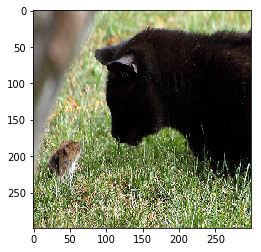

In [4]:
images = transform_img_fn([os.path.join('data','cat_mouse.jpg')])
# I'm dividing by 2 and adding 0.5 because of how this Inception represents images
plt.imshow(images[0] / 2 + 0.5)
preds = inet_model.predict(images)
for x in decode_predictions(preds)[0]:
    print(x)

### Lets try 3 images of Grumpy Cat

('n02123597', 'Siamese_cat', 0.64242667)
('n02123394', 'Persian_cat', 0.11569989)
('n03325584', 'feather_boa', 0.005399013)
('n02123045', 'tabby', 0.00516225)
('n02883205', 'bow_tie', 0.0048343805)


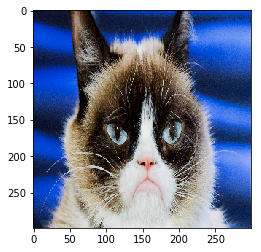

In [5]:
images = transform_img_fn([os.path.join('data','Grumpy_cat1.jpg')])
# I'm dividing by 2 and adding 0.5 because of how this Inception represents images
plt.imshow(images[0] / 2 + 0.5)
preds = inet_model.predict(images)
for x in decode_predictions(preds)[0]:
    print(x)

('n02123597', 'Siamese_cat', 0.83967274)
('n02123394', 'Persian_cat', 0.035791747)
('n02123045', 'tabby', 0.0033506877)
('n02883205', 'bow_tie', 0.0033280163)
('n03482405', 'hamper', 0.0022052254)


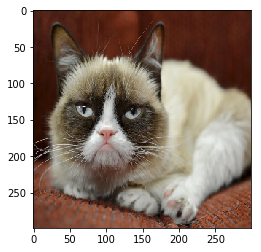

In [6]:
images2 = transform_img_fn([os.path.join('data','Grumpy_cat2.jpg')])
# I'm dividing by 2 and adding 0.5 because of how this Inception represents images
plt.imshow(images2[0] / 2 + 0.5)
preds = inet_model.predict(images2)
for x in decode_predictions(preds)[0]:
    print(x)

## Explanation
Now let's get an explanation

('n02123597', 'Siamese_cat', 0.6491023)
('n02123394', 'Persian_cat', 0.11358318)
('n02123045', 'tabby', 0.0121339)
('n02883205', 'bow_tie', 0.008717649)
('n02127052', 'lynx', 0.008351362)


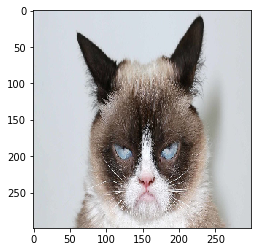

In [7]:
images3 = transform_img_fn([os.path.join('data','Grumpy_cat3.jpg')])
# I'm dividing by 2 and adding 0.5 because of how this Inception represents images
plt.imshow(images3[0] / 2 + 0.5)
preds = inet_model.predict(images3)
for x in decode_predictions(preds)[0]:
    print(x)

In [9]:
%load_ext autoreload
%autoreload 2
import os,sys
try:
    import lime
except:
    sys.path.append(os.path.join('..', '..')) # add the current directory
    import lime
from lime import lime_image

In [10]:
explainer = lime_image.LimeImageExplainer()

hide_color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels. Here, we set it to 0 (in the representation used by inception model, 0 means gray)

In [11]:

# Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
explanation1 = explainer.explain_instance(images[0], inet_model.predict, top_labels=5, hide_color=0, num_samples=1000)
explanation2 = explainer.explain_instance(images2[0], inet_model.predict, top_labels=5, hide_color=0, num_samples=1000)
explanation3 = explainer.explain_instance(images3[0], inet_model.predict, top_labels=5, hide_color=0, num_samples=1000)

Image classifiers are a bit slow. Notice that an explanation on my Surface Book dGPU took 1min 29s

In [12]:
print(explanation1.top_labels)
print(explanation2.top_labels)
print(explanation3.top_labels)

[284, 283, 552, 281, 457]
[284, 283, 281, 457, 588]
[284, 283, 281, 457, 287]


### Now let's see the explanation for the top class ( Black Bear)

We can see the top 5 superpixels that are most positive towards the class with the rest of the image hidden

In [13]:
from skimage.segmentation import mark_boundaries

#### Grumpy Cat 1

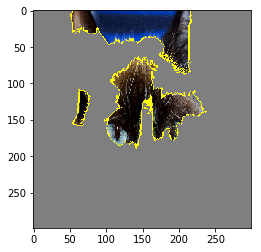

In [15]:
temp, mask = explanation1.get_image_and_mask(284, positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

Or with the rest of the image present:

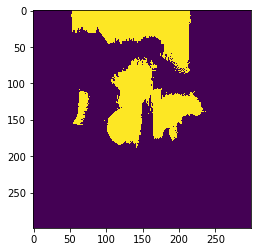

In [16]:
plt.imshow((mask / 2 + 0.5))

#### Grumpy Cat 2

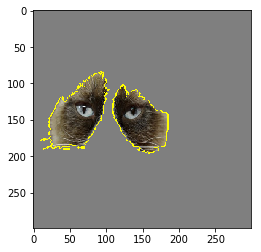

In [17]:
temp2, mask2 = explanation2.get_image_and_mask(284, positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp2 / 2 + 0.5, mask2))

#### Grumpy Cat 3

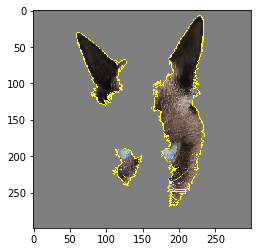

In [19]:
temp3, mask3 = explanation3.get_image_and_mask(284, positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp3 / 2 + 0.5, mask3))

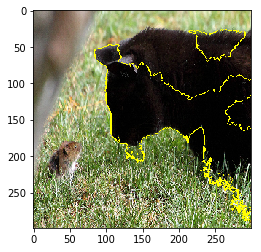

In [25]:
temp, mask = explanation1.get_image_and_mask(295, positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))


We can also see the 'pros and cons' (pros in green, cons in red)

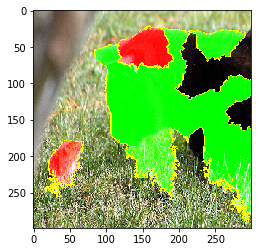

In [26]:
temp, mask = explanation1.get_image_and_mask(295, positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

Or the pros and cons that have weight at least 0.1

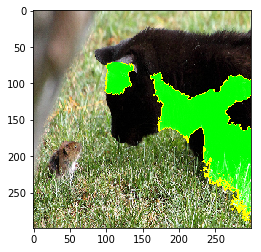

In [27]:
temp, mask = explanation1.get_image_and_mask(295, positive_only=False, num_features=1000, hide_rest=False, min_weight=0.1)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

### Let's see the explanation for Wombat

Most positive towards wombat:

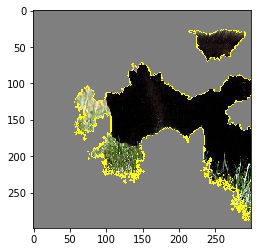

In [28]:
temp, mask = explanation1.get_image_and_mask(106, positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

Pros and cons:

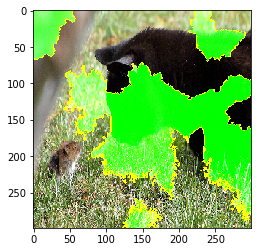

In [29]:
temp, mask = explanation1.get_image_and_mask(106, positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))


In [30]:
explanation1.top_labels

[295, 224, 223, 106, 104]

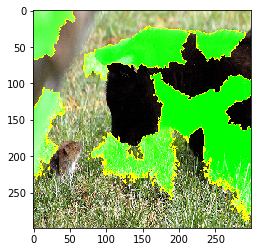

In [42]:
temp, mask = explanation1.get_image_and_mask(104, positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
